Steps to follow:
1. Collect the stock data -- Apple
2. Preprocess the Data- Train and Test
3. Create a Stacked LSTM model
4. Predict the test data and plot the output
5. Predict the future 30 days and plot the output

In [ ]:
# Data Collection
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import math
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [ ]:
df = pdr.get_data_tiingo('AAPL', api_key='c0b71604c19181cf82317e895e64fbcc9d1c3326')
df.to_csv('AAPL.csv')

/usr/local/lib/python3.9/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [ ]:
df = pd.read_csv('AAPL.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2018-03-22 00:00:00+00:00,168.85,172.68,168.60,170.00,41051076,40.187582,41.099151,40.128080,40.461291,164204304,0.0,1.0
1,AAPL,2018-03-23 00:00:00+00:00,164.94,169.92,164.94,168.39,40248954,39.256972,40.442250,39.256972,40.078099,160995816,0.0,1.0
2,AAPL,2018-03-26 00:00:00+00:00,172.77,173.10,166.44,168.07,36272617,41.120572,41.199114,39.613984,40.001936,145090468,0.0,1.0
3,AAPL,2018-03-27 00:00:00+00:00,168.34,175.15,166.92,173.68,38962839,40.066198,41.687030,39.728227,41.337159,155851356,0.0,1.0
4,AAPL,2018-03-28 00:00:00+00:00,166.48,170.02,165.19,167.25,41668545,39.623504,40.466051,39.316474,39.806770,166674180,0.0,1.0


In [ ]:
# Doing this for CLOSE Column
df1 = df.reset_index()['close']

In [ ]:
df1.shape

(1258,)

In [ ]:
df1

0       168.85
1       164.94
2       172.77
3       168.34
4       166.48
         ...  
1253    152.99
1254    155.85
1255    155.00
1256    157.40
1257    159.28
Name: close, Length: 1258, dtype: float64

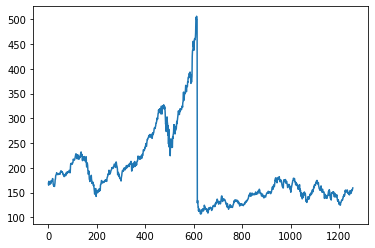

In [ ]:
plt.plot(df1)

In [ ]:
# LSTM are sensitive to the scale of the data, so we apply MinMax Scaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(1258, 1)

In [ ]:
# Splitting dataset into train and test
# Time series data split based on date
training_size = int(len(df1)*0.65) 
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
len(train_data), len(test_data)

(817, 441)

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset) - time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i +time_step, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
# Reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train)

[[0.15531622 0.14552286 0.16513463 ... 0.25557921 0.25219787 0.25555416]
 [0.14552286 0.16513463 0.15403882 ... 0.25219787 0.25555416 0.2577583 ]
 [0.16513463 0.15403882 0.14938009 ... 0.25555416 0.2577583  0.2589856 ]
 ...
 [0.07521603 0.08072636 0.09036944 ... 0.0482655  0.05137132 0.05921102]
 [0.08072636 0.09036944 0.09097057 ... 0.05137132 0.05921102 0.05710708]
 [0.09036944 0.09097057 0.0882154  ... 0.05921102 0.05710708 0.05838447]]


In [ ]:
print(X_train.shape), print(y_train.shape) 

(716, 100)
(716,)


(None, None)

In [ ]:
print(X_test.shape), print(y_test.shape)

(340, 100)
(340,)


(None, None)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [ ]:
# Create the Stacked LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences= True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64,verbose=1)


Epoch 1/100
12/12 [==============================] - 11s 411ms/step - loss: 0.0268 - val_loss: 5.0656e-04
Epoch 2/100
12/12 [==============================] - 3s 225ms/step - loss: 0.0134 - val_loss: 0.0041
Epoch 3/100
12/12 [==============================] - 3s 249ms/step - loss: 0.0100 - val_loss: 6.5898e-04
Epoch 4/100
12/12 [==============================] - 4s 311ms/step - loss: 0.0091 - val_loss: 3.6575e-04
Epoch 5/100
12/12 [==============================] - 3s 230ms/step - loss: 0.0076 - val_loss: 7.5895e-04
Epoch 6/100
12/12 [==============================] - 3s 232ms/step - loss: 0.0065 - val_loss: 4.0288e-04
Epoch 7/100
12/12 [==============================] - 3s 225ms/step - loss: 0.0056 - val_loss: 3.8454e-04
Epoch 8/100
12/12 [==============================] - 3s 294ms/step - loss: 0.0054 - val_loss: 6.7402e-04
Epoch 9/100
12/12 [==============================] - 3s 244ms/step - loss: 0.0053 - val_loss: 5.3346e-04
Epoch 10/100
12/12 [==============================] - 3s 2

In [ ]:
# Prediction and check performance metrices
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE performace metrices
math.sqrt(mean_squared_error(y_train, train_predict))

11/11 [==============================] - 1s 47ms/step


229.55027996298884

In [ ]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

156.21606398708144

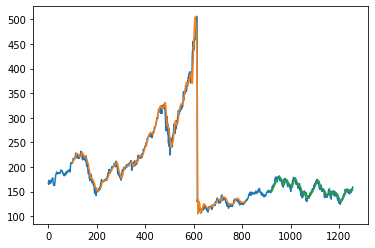

In [ ]:
# Plotting
#Shift predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

#plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
 len(test_data)

441

In [ ]:
x_input = test_data[340:].reshape(1,-1)
x_input.shape

(1, 101)

In [ ]:
x_input = test_data[340:].reshape(1,-1)

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
# Predictions for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
  if(len(temp_input)>100):
    x_input = np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape(1, n_steps ,1)

    yhat = model.predict(x_input, verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    lst_output.extend(yhat.tolist())
    i=i+1
  
  else:
    x_input = x_input.reshape((1, n_steps,1))
    yhat = model.predict(x_input, verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i=i+1
    
print(lst_output)

0 day input [0.10647464 0.09507827 0.12247965 0.11646838 0.10973075 0.09565435
 0.08025047 0.07899812 0.08035066 0.08180338 0.07020664 0.10026299
 0.10735128 0.10379461 0.10820288 0.10507201 0.10990607 0.11133375
 0.10311835 0.10855354 0.11078272 0.10336882 0.09362555 0.08598622
 0.10316844 0.10386976 0.10261741 0.09966187 0.0903444  0.08541014
 0.08969317 0.08846587 0.09430182 0.09675642 0.0910958  0.07428929
 0.06930495 0.0639449  0.06376957 0.07165936 0.06359424 0.0626675
 0.05808391 0.04809017 0.05703193 0.05783344 0.04566061 0.04889167
 0.04553538 0.05705698 0.05838447 0.05983719 0.06675016 0.06654978
 0.06993112 0.07288666 0.07105823 0.07120852 0.07772073 0.08583594
 0.08939261 0.08771446 0.09297433 0.09790858 0.09056982 0.09380088
 0.09665623 0.11015654 0.11937383 0.11243582 0.11974953 0.11291171
 0.11028178 0.11063244 0.11774577 0.11611772 0.12145272 0.11739512
 0.11448967 0.10429555 0.10537257 0.10659987 0.09986224 0.10289292
 0.10161553 0.09635567 0.09785848 0.11068253 0.1176

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

1258

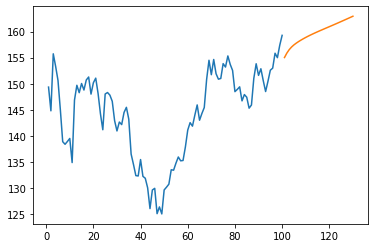

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

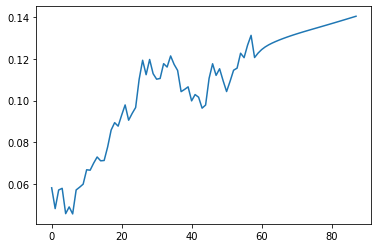

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

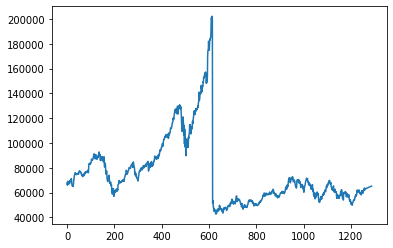

In [ ]:
plt.plot(df3)